In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")
sns.set_palette("CMRmap_r")

import sklearn
from sklearn.model_selection import train_test_split

print('Setup Complete.')

print(os.listdir('./data'))

Setup Complete.
['heart.csv']


In [2]:
df = pd.read_csv('./data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
!pip install eli5
!pip install shap
!pip install pdpbox

     |████████████████████████████████| 105 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 319 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 7.5 MB/s eta 0:00:011
     |████████████████████████████████| 2.2 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 18.4 MB 7.4 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.36.0-cp38-cp38-macosx_10_9_x86_64.whl size=371423 sha256=54de300e03add754e819c7fc9f4ecc37b4d2ade930241bf39a74dc2893fb20b9
  Stored in directory: /Users/jordansamek/Library/Caches/pip/wheels/95/cb/07/4fad1b66b2085b03eab34848c37d47d0782c53e3e57d277e8d
Successfully built shap
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kaggle 1.5.6 requires requests, which is not ins

In [3]:
# Scikit-learn and other imports

# Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Models we'll be using and testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, info_plots

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

/Users/jordansamek/opt/miniconda3/envs/heart-disease/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jordansamek/opt/miniconda3/envs/heart-disease/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Let's take a look at our columns again and see what the abbreviations mean.

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


What do we have...

- **age** - The patient's age in years
- **sex** - The gender of the patient (1 = male; 0 = female)
- **cp** - Chest pain experienced (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
- **trestbps** - The resting heart rate of the patient (measured in mmHg)
- **chol** - Serum cholesterol level (measured in mg/dl)
- **fbs** - Fasting blood sugar (> 120 mg/dl; 1 = true, 0 = false)
- **restecg** - Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing -probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach** - The patient's maximum heart rate achieved
- **exang** - Exercise induced angina (1 = yes; 0 = no)
- **oldpeak** - ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
- **slope** - The slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
- **ca** - The number of major vessels (0-3)
- **thal** - A blodd disorder called Thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target** - Heart disease (0 = no; 1 = yes)

We'll change a few of these columns around for better interpretability.

In [5]:
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar',
             'rest_ecg', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'st_slope',
             'num_major_vessels', 'thalassemia', 'target']

We'll also change around some of the values for the categorical variables for better interpretability of the dataset.

In [6]:
df['sex'][df['sex'] == 0] = 'female'
df['sex'][df['sex'] == 1] = 'male'

df['chest_pain_type'][df['chest_pain_type'] == 1] = 'typical angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'atypical angina'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'non-angina pain'
df['chest_pain_type'][df['chest_pain_type'] == 4] = 'asymptomatic'

df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

df['rest_ecg'][df['rest_ecg'] == 0] = 'normal'
df['rest_ecg'][df['rest_ecg'] == 1] = 'ST-T wave abnormality'
df['rest_ecg'][df['rest_ecg'] == 2] = 'left ventricular hypertrophy'

df['exercise_induced_angina'][df['exercise_induced_angina'] == 0] = 'no'
df['exercise_induced_angina'][df['exercise_induced_angina'] == 1] = 'yes'

df['st_slope'][df['st_slope'] == 1] = 'upsloping'
df['st_slope'][df['st_slope'] == 2] = 'flat'
df['st_slope'][df['st_slope'] == 3] = 'downsloping'

df['thalassemia'][df['thalassemia'] == 1] = 'normal'
df['thalassemia'][df['thalassemia'] == 2] = 'fixed defect'
df['thalassemia'][df['thalassemia'] == 3] = 'reversable defect'

In [7]:
df.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

For categorical variables, we need to create dummy variables so they can be classified as numeric types rather than categorical. We'll drop the first category of each, so rather than having a 'male' and 'female' column separately, we'll have a 'male' column with a 1 or 0 representing it being a male or not.

In [8]:
df = pd.get_dummies(df, drop_first=True)

In [9]:
df.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-angina pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [10]:
df.shape

(303, 20)

Let's start to set up our models for machine learning. We split the dataset into an X and y dataset, separating our dependent and independent variables. Then we will further split our data into training and test sets.

In [11]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(242, 19)
(61, 19)
(242,)
(61,)


In [12]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

We can plot the decision tree to see what splits it's making.

In [13]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [15]:
!pip install pydot

In [16]:
!pip install graphviz

In [31]:
os.environ["PATH"] += os.pathsep + '/Users/jordansamek/.local/lib/python3.8/site-packages/graphviz'
import graphviz
dot_data = export_graphviz(estimator, out_file='tree.dot',
               feature_names=feature_names,
               class_names=y_train_str,
               rounded=True,
               proportion=True,
               label='root',
               precision=2,
               filled=True)

from subprocess import call
call(['dot', '-Tsvg', 'tree.dot', '-o', 'tree.png', '-Gpdi=600'], shell=True)

import pydot
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


from IPython.display import Image
Image(filename='tree.png')

FileNotFoundError: [Errno 2] "dot" not found in path.

In [32]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [33]:
conf_mx = confusion_matrix(y_test, y_pred_bin)
conf_mx

array([[26,  3],
       [ 6, 26]])

Next we'll look at precision and recall, also known as **sensitivity** and **specificity**.

In [42]:
from sklearn.metrics import precision_score, recall_score

print(f"Specificity: {precision_score(y_pred_bin, y_test)*100:.2f}%")
print(f"Sensitivity: {recall_score(y_pred_bin, y_test)*100:.2f}%")

Specificity: 81.25%
Sensitivity: 89.66%


We'll have a look at the ROC Curve.

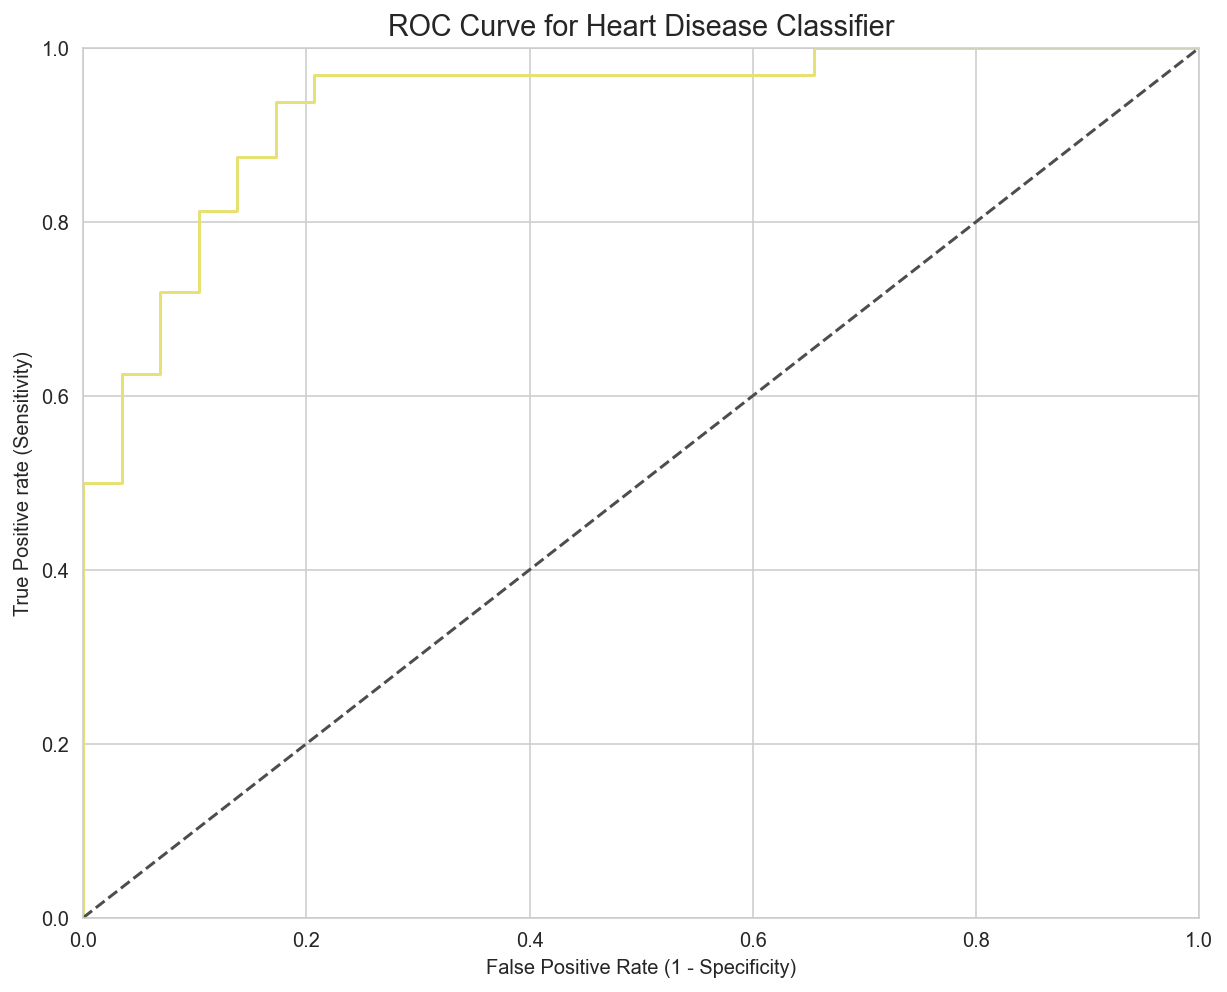

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="0.3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC Curve for Heart Disease Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive rate (Sensitivity)')
plt.grid(True)

In [44]:
# AUC score (Area Under the Curve)
auc(fpr, tpr)

0.9331896551724139

Let's work on an explanation of the scores and the model.

**Permutation Importance** involves shuffling individual variables in the validation set, and seeing the effect on accuracy.

In [45]:
perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0230 ± 0.0533,st_depression
0.0197 ± 0.0245,thalassemia_reversable defect
0.0131 ± 0.0382,exercise_induced_angina_yes
0.0098 ± 0.0161,num_major_vessels
0.0066 ± 0.0161,sex_male
0.0066 ± 0.0393,st_slope_flat
0.0033 ± 0.0131,chest_pain_type_non-angina pain
0 ± 0.0000,thalassemia_normal
0 ± 0.0000,cholesterol
0 ± 0.0000,chest_pain_type_typical angina


Here we can see that the most important features in terms of permutation is st depression, thalassemia result of reversible defect, and exercise induced angina. 

Let's look closer at the number of major vessels using a Partial Dependence Plot. These types of plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect.

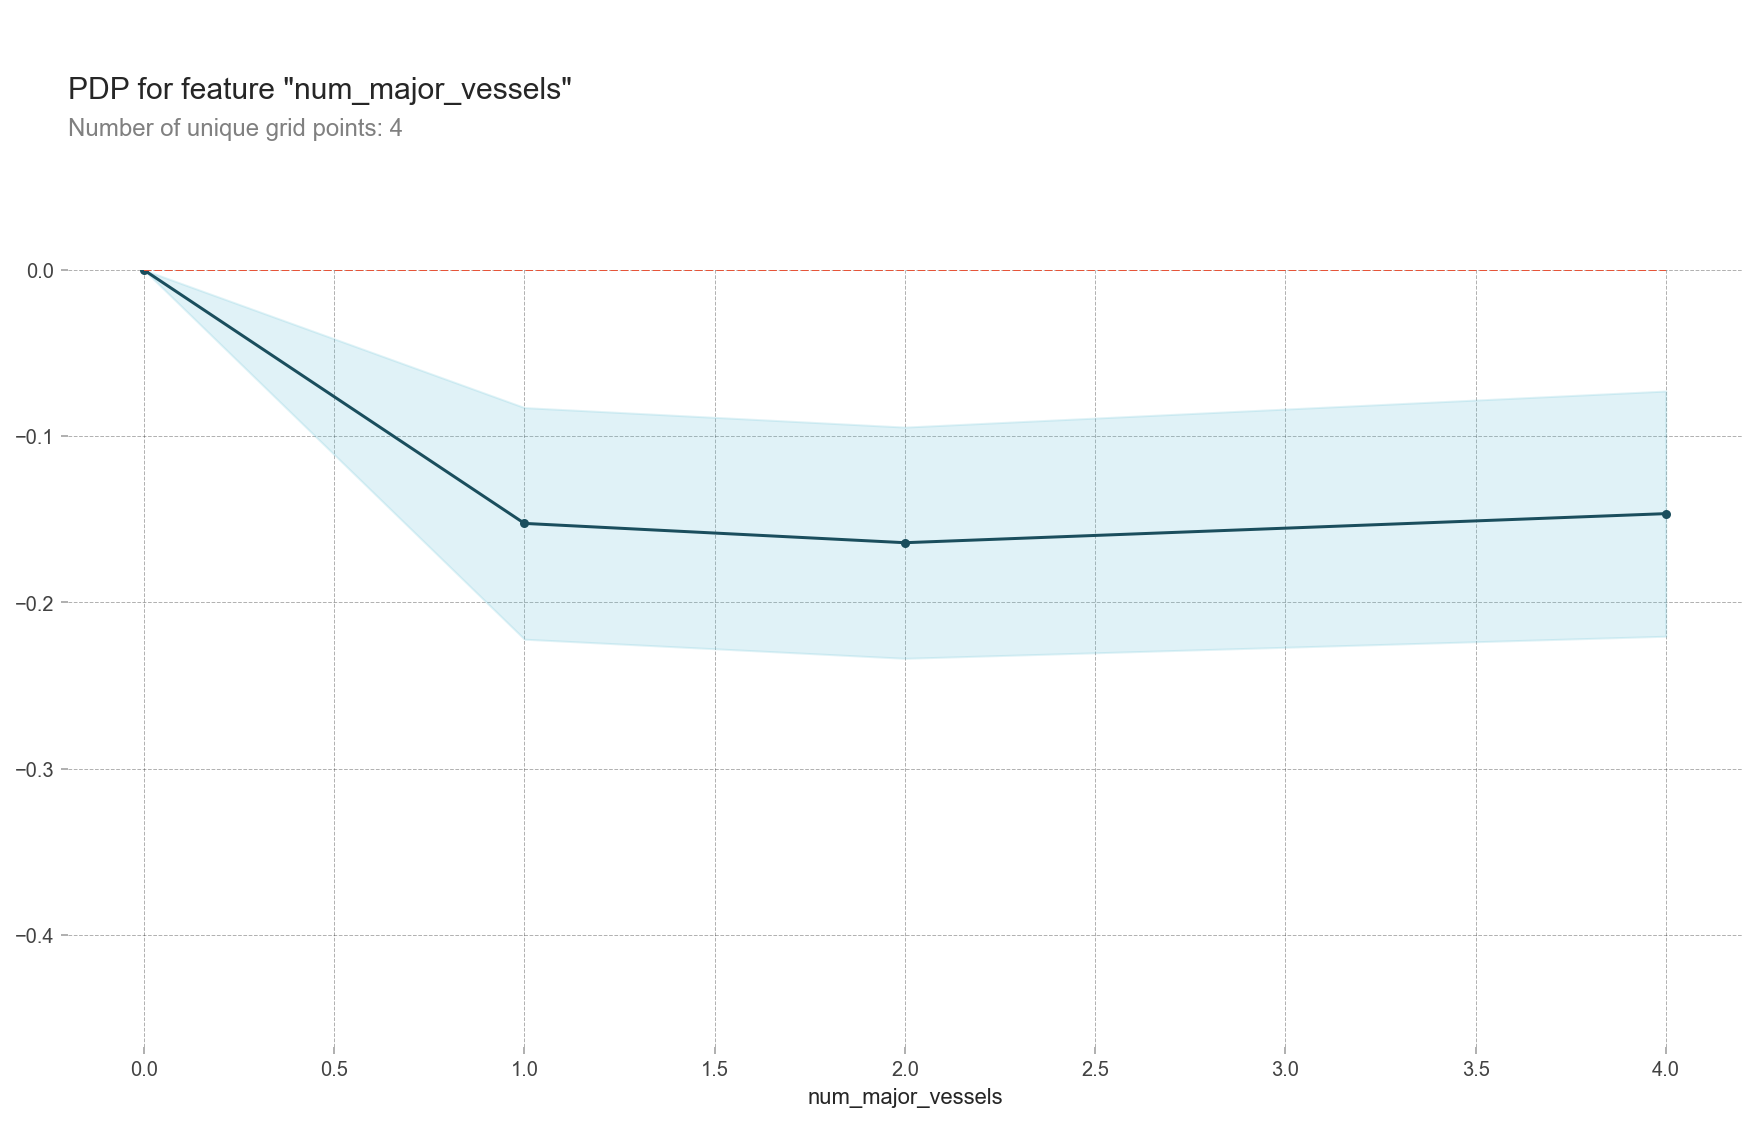

In [47]:
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

As the number of major blood vessels increases, the probability of heart disease decreases. This makes sense as it means more blood can get to the heart.

What about **age**?

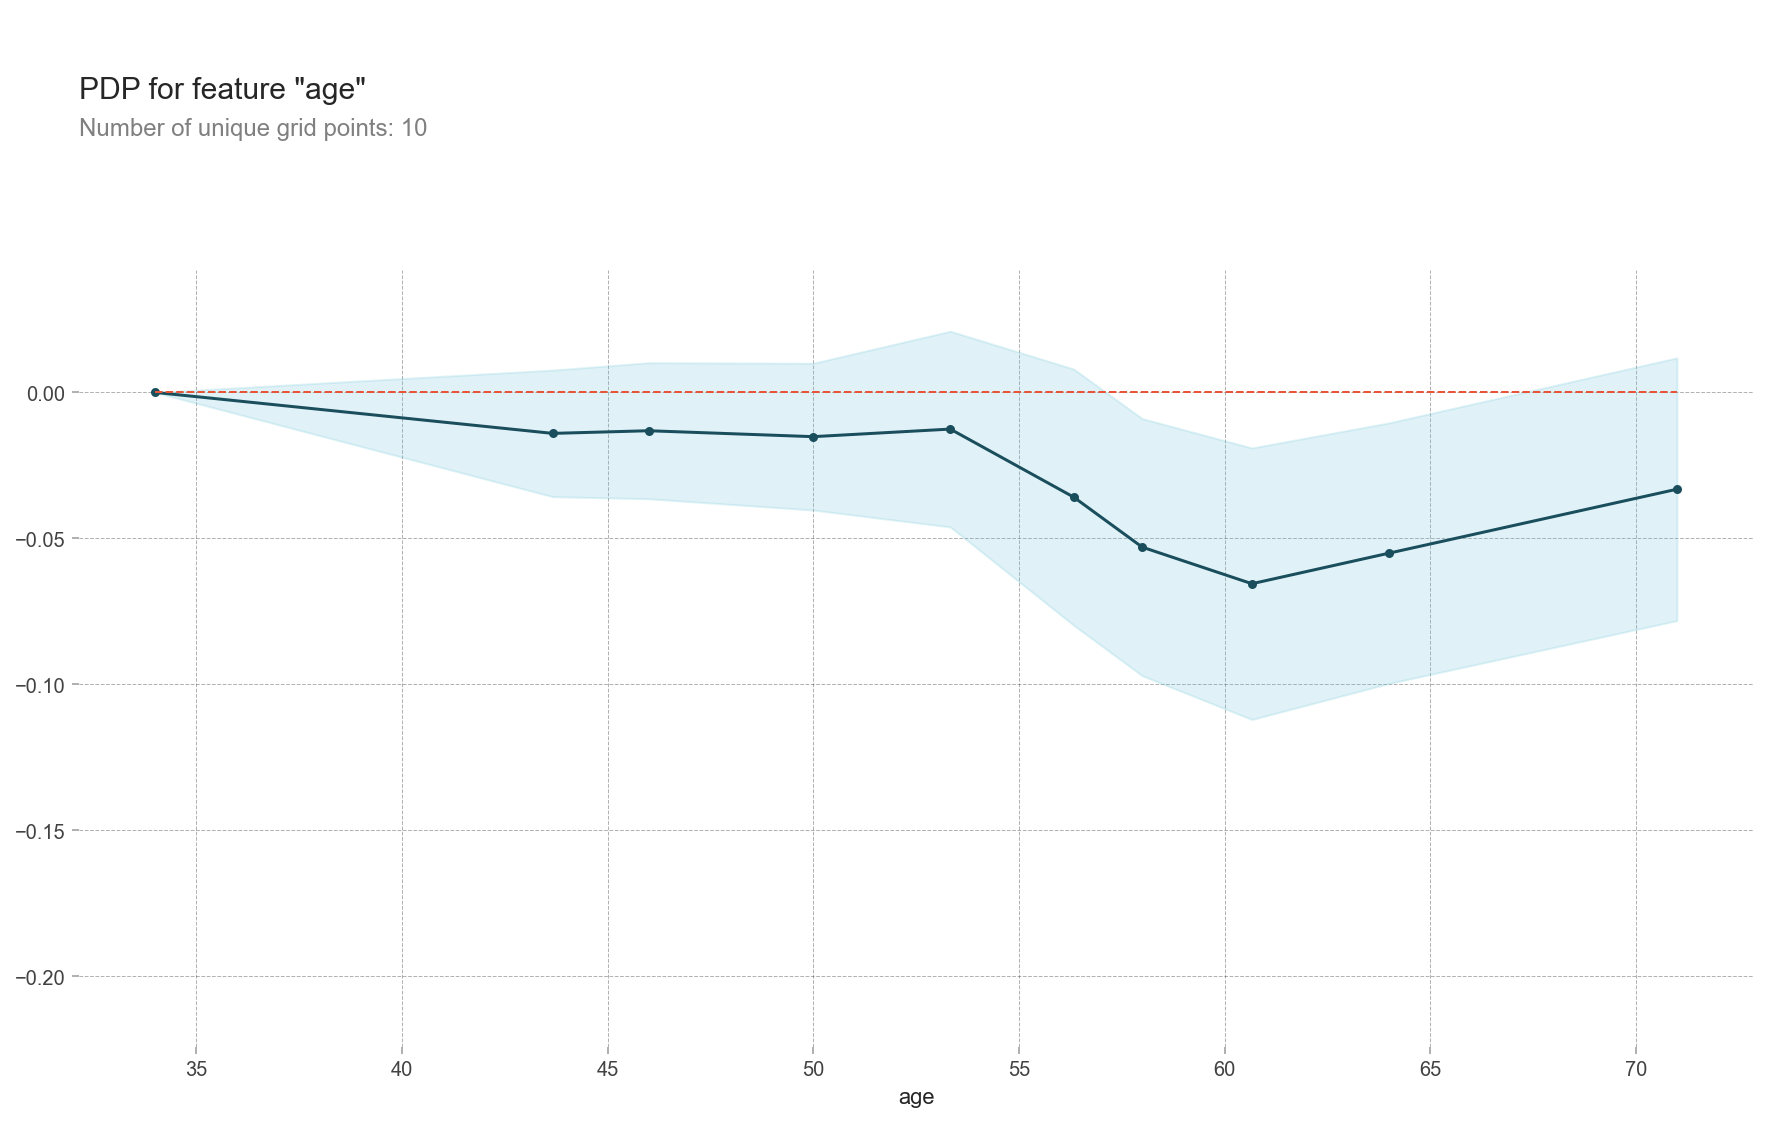

In [48]:
feat_name = 'age'

pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show();

Looking at this plot, it seems odd that the older the patient is, there is less risk of heart disease. Although the red baseline (confidence region) shows that this might not be true.

What about **st_depression**?

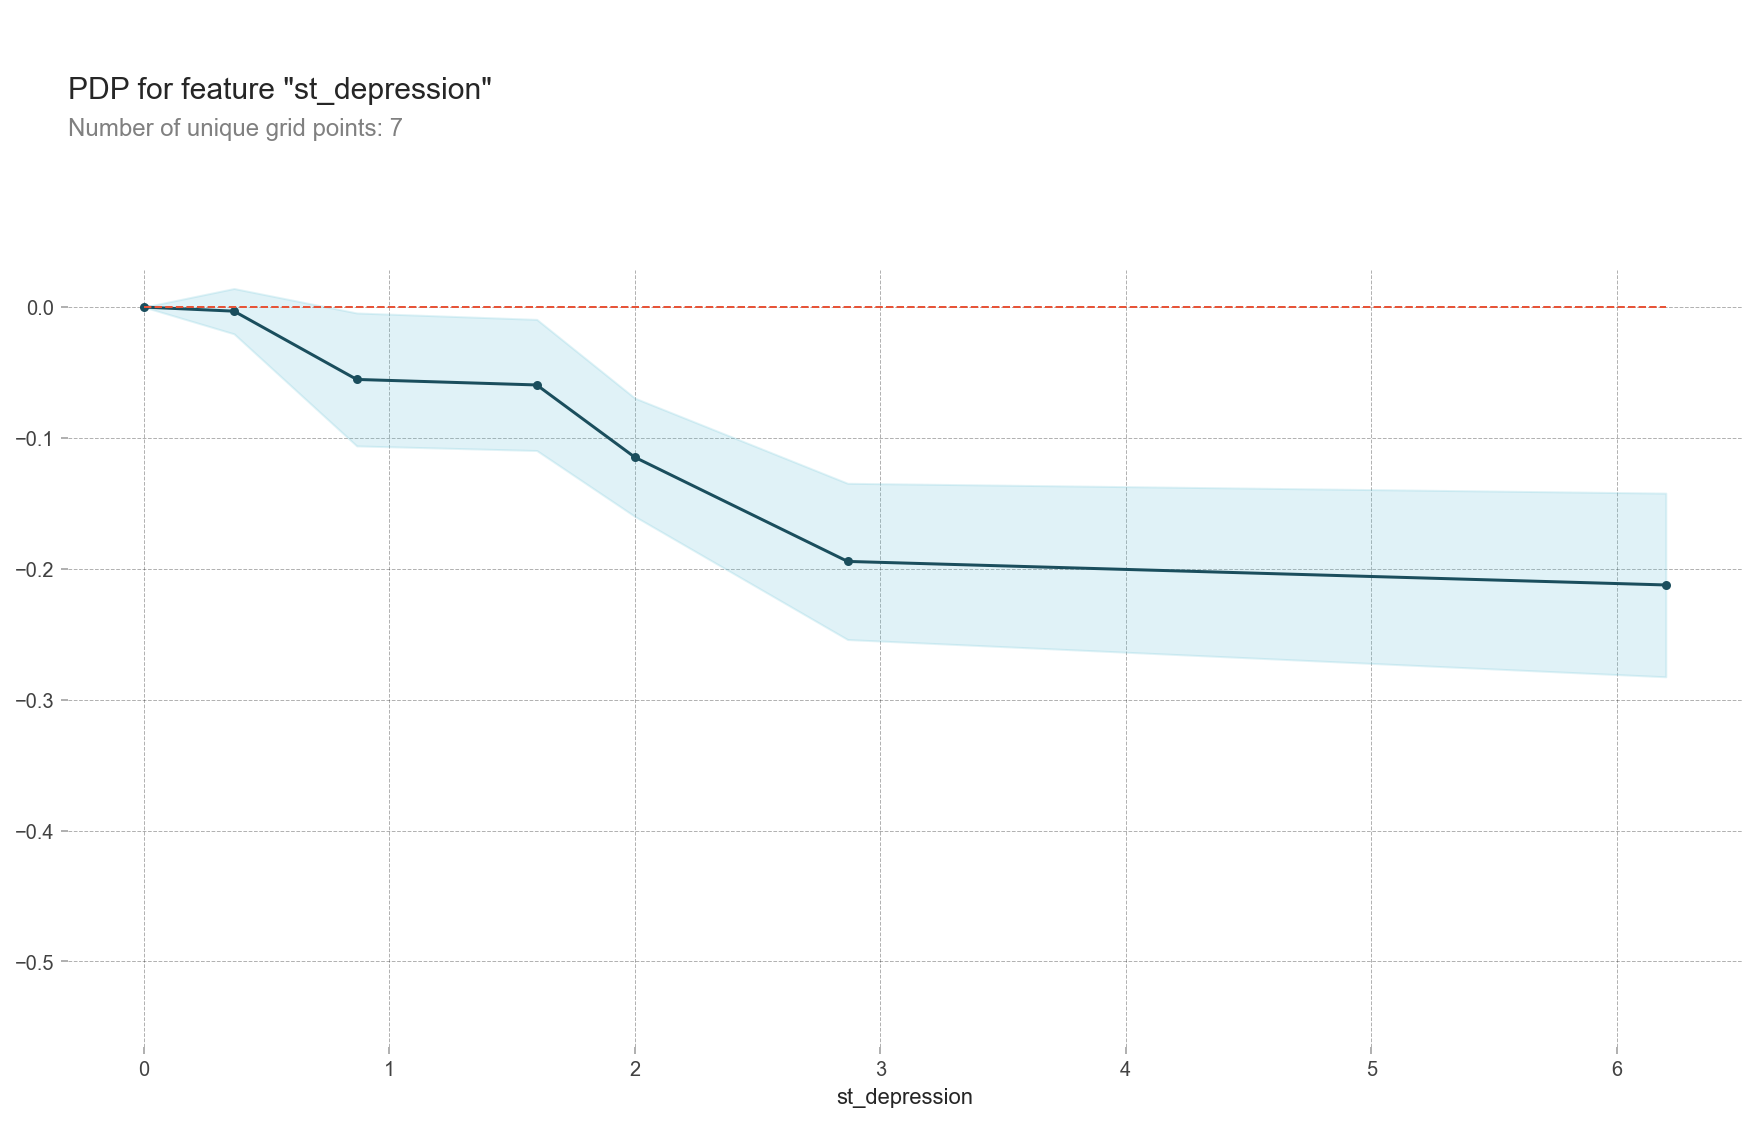

In [49]:
feat_name = 'st_depression'

pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show();